# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [56]:
# загружу библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [57]:
# загружу и ознакомлюсь с датасетами по регионам бурения
df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv') # регион № 1
df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv') # регион № 2
df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv') # регион № 3
display(df_1.head())
display(df_2.head())
display(df_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [58]:
# посмотрю на тип данных и наличие пропусков
display(df_1.info())
display(df_2.info())
display(df_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков нет, id имеет тип object

In [59]:
# проверю на уникальные значения
display(df_1.nunique())
display(df_2.nunique())
display(df_3.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Возникли вопросы по значениям в id, скорее всего дубли скважин

А также странные значения в product - 2 регион

In [60]:
# проверю уникальные значения в 'id'
df_1['id'].value_counts()

fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
        ..
x8osI    1
gZ7tR    1
Zw8hj    1
zcrQO    1
1CWhH    1
Name: id, Length: 99990, dtype: int64

In [61]:
df_1[df_1['id'] == 'Tdehs'].head()

,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


Наименование одно, а данные другие.

id исключу при обучении, т.к. он никакой значимости не несет для прогноза. Суть модели в прогнозе количества сырья на основе характеристик скважины, а сопоставление по id совершенно не нужно, к тому же там странное поведение.

In [62]:
df_1 = df_1.drop('id', axis=1)
df_2 = df_2.drop('id', axis=1)
df_3 = df_3.drop('id', axis=1)

Т.к. объём запасов в скважине измеряется в тыс. баррелей, то, пожалуй, округлю и уберу все значения после запятой.

In [63]:
df_1['product']

0        105.280062
1         73.037750
2         85.265647
3        168.620776
4        154.036647
            ...    
99995    110.744026
99996    122.346843
99997     64.375443
99998     74.040764
99999    149.633246
Name: product, Length: 100000, dtype: float64

In [64]:
df_1['product'] = df_1['product'].round(0).astype('Int64')
df_2['product'] = df_2['product'].round(0).astype('Int64')
df_3['product'] = df_3['product'].round(0).astype('Int64')

In [65]:
df_2['product'].value_counts() 

54     8472
27     8468
84     8431
57     8390
3      8337
81     8320
30     8306
135    8304
111    8303
0      8235
138    8233
108    8201
Name: product, dtype: Int64

Могу сделать предположение, что данную категорию поделили на 12 выборок по примерно равным объемам

In [66]:
# посмотрю основные статистические значения
display(df_1.describe())
display(df_2.describe())
display(df_3.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500620
std,0.871832,0.504433,3.248248,44.289494
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.000000
50%,0.502360,0.250252,2.515969,92.000000
75%,1.073581,0.700646,4.715088,129.000000
max,2.362331,1.343769,16.003790,185.000000


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.00000
mean,1.141296,-4.796579,2.494541,68.85204
std,8.965932,5.119872,1.703572,46.02096
min,-31.609576,-26.358598,-0.018144,0.00000
25%,-6.298551,-8.267985,1.000021,27.00000
50%,1.153055,-4.813172,2.011479,57.00000
75%,8.621015,-1.332816,3.999904,108.00000
max,29.421755,18.734063,5.019721,138.00000


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,94.998580
std,1.732045,1.730417,3.473445,44.751123
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.000000
50%,0.009424,-0.009482,2.484236,95.000000
75%,1.158535,1.163678,4.858794,131.000000
max,7.238262,7.844801,16.739402,190.000000


In [67]:
# функция для построения графика по product для 3 регионов
def show_me_hist(df, i):
    df[df.columns.values[i]].hist(bins=50)
    plt.xlabel('count')
    plt.ylabel('frequency')
    plt.title(df.columns.values[i])
    plt.show()

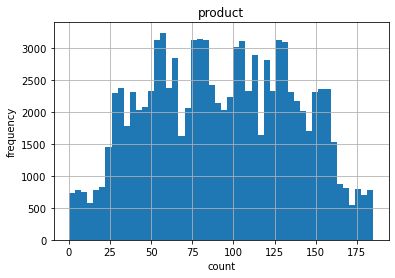

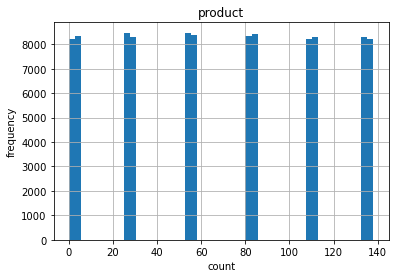

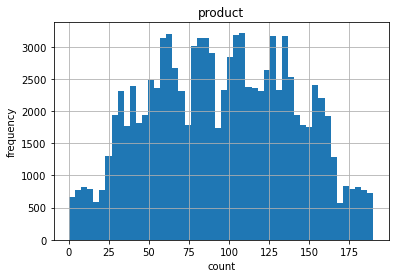

In [68]:
show_me_hist(df_1, 3)
show_me_hist(df_2, 3)
show_me_hist(df_3, 3)

**Вывод**

- Регион 1 - среднее и медианы равны, ср.кв.отклонение 44, нормальное распределение;
- Регион 2 - среднее выше, чем медиана, значит больше скважин с большими значениями. На графике "небоскрёбы". Значения запасов меньше, чем в регионе 1 и 3;
- Регион 3 - данные такие же как в регионе 1, но запасов чуть больше.

## Обучение и проверка модели

In [69]:
rnd = np.random.RandomState(12345)

In [70]:
# выделю целевой признак
X_1 = df_1.drop('product', axis=1)
y_1 = df_1['product']
X_2 = df_2.drop('product', axis=1)
y_2 = df_2['product']
X_3 = df_3.drop('product', axis=1)
y_3 = df_3['product']

In [71]:
# разобью выборки на тренировочную и валидационную (стратифицированные)
X_tr_1, X_v_1, y_tr_1, y_v_1 = train_test_split(X_1, y_1, test_size=0.25, stratify = y_1, random_state=42)
X_tr_2, X_v_2, y_tr_2, y_v_2 = train_test_split(X_2, y_2, test_size=0.25, stratify = y_2, random_state=42)
X_tr_3, X_v_3, y_tr_3, y_v_3 = train_test_split(X_3, y_3, test_size=0.25, stratify = y_3, random_state=42)

In [72]:
# проверю, как разбились выборки
print(X_tr_1.shape, X_v_1.shape, y_tr_1.shape, y_v_1.shape)

(75000, 3) (25000, 3) (75000,) (25000,)


In [73]:
# обучу линейную регрессию на данных 3-х регионов
lr_1 = LinearRegression()
lr_2 = LinearRegression()
lr_3 = LinearRegression()
lr_1.fit(X_tr_1, y_tr_1)
lr_2.fit(X_tr_2, y_tr_2)
lr_3.fit(X_tr_3, y_tr_3)

LinearRegression()

In [74]:
# получу предсказания и занесу их в переменные
pred_1 = lr_1.predict(X_v_1)
pred_2 = lr_2.predict(X_v_2)
pred_3 = lr_3.predict(X_v_3)

In [75]:
# переведу предсказания в Series
pred_1 = pd.Series(pred_1)
pred_2 = pd.Series(pred_2)
pred_3 = pd.Series(pred_3)

In [76]:
# верные ответы, сброшу индексы для дальнейших расчетов
target_1 = y_v_1.reset_index(drop=True)
target_2 = y_v_2.reset_index(drop=True)
target_3 = y_v_3.reset_index(drop=True)

In [77]:
# Cредний запас предсказанного сырья и RMSE модели_1
print('Средний запас предсказанного сырья_1: {:.2f}'.format(pred_1.mean()))
print('RMSE модели_1: {:.2f}'.format(mean_squared_error(target_1, pred_1)**0.5))
# Cредний запас предсказанного сырья и RMSE модели_2
print('Средний запас предсказанного сырья_2: {:.2f}'.format(pred_2.mean()))
print('RMSE модели_2: {:.2f}'.format(mean_squared_error(target_2, pred_2)**0.5))
# Cредний запас предсказанного сырья и RMSE модели_3
print('Средний запас предсказанного сырья_3: {:.2f}'.format(pred_3.mean()))
print('RMSE модели_3: {:.2f}'.format(mean_squared_error(target_3, pred_3)**0.5))


Средний запас предсказанного сырья_1: 92.48
RMSE модели_1: 37.81
Средний запас предсказанного сырья_2: 68.85
RMSE модели_2: 0.84
Средний запас предсказанного сырья_3: 94.94
RMSE модели_3: 39.88


**Вывод**

- Средний запас предсказанного сырья практически соответствует средним значениям запасов первоначальных данных;
- Минимальная метрика RMSE достигнута в регионе № 2, хуже всего предсказывает модель региона № 3, RMSE = 39,88;
- Модель № 2, скорее всего, так справилась из-за предварительно сгруппированных данных по запасам (12 подвыборок).

## Подготовка к расчёту прибыли

In [78]:
# создам константы и рассчитаю минимальный запас в скважине
# для безубыточной разработки месторождения
BUDGET = 10000000000
PRICE_BAR = 450000
PROFIT_0 = BUDGET / 200 / PRICE_BAR
MLRD = 1000000000
print('Объём сырья для безубыточной разработки одной скважины: {:.2f} тыс. баррелей'.format(PROFIT_0))

Объём сырья для безубыточной разработки одной скважины: 111.11 тыс. баррелей


In [79]:
print("Средний истинный запас сырья в регионах, тыс. баррелей:")
print()
count = 0
targets = [target_1, target_2, target_3]
for target in targets:
    count += 1
    print('Регион ', count,': ',  target.mean())

Средний истинный запас сырья в регионах, тыс. баррелей:

Регион  1 :  92.50456
Регион  2 :  68.85096
Регион  3 :  94.99448


**Вывод**

- Чтобы получать прибыль, нужно будет выбать скважины с запасами выше 111.11 тыс.баррелей;
- Средние запасы каждого из регионов меньше необходимого запаса для безубыточной разработки, но ср.кв.ошибка говорит о том, что верные ответы целевого признака имеют большие запасы.

## Расчёт прибыли и рисков 

In [80]:
# создам функцию по расчету прибыли при разработки n-лучших скважин
def profit(target, predict, count):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    return PRICE_BAR * selected.sum() - BUDGET

In [81]:
# определю максимальную прибыль с региона, при выборе 200 лучших скважин
print('Прибыль региона № 1 (200 лучших скважин): {} млрд.рублей'.format(profit(target_1, pred_1, 200) / MLRD))
print('Прибыль региона № 2 (200 лучших скважин): {} млрд.рублей'.format(profit(target_2, pred_2, 200) / MLRD))
print('Прибыль региона № 3 (200 лучших скважин): {} млрд.рублей'.format(profit(target_3, pred_3, 200) / MLRD))

Прибыль региона № 1 (200 лучших скважин): 3.41675 млрд.рублей
Прибыль региона № 2 (200 лучших скважин): 2.42 млрд.рублей
Прибыль региона № 3 (200 лучших скважин): 2.56175 млрд.рублей


Максимальная прибыль у региона 1

In [82]:
# исходя из условий задачи я исследую 500 точек, а выбираю 200 лучших.
# найду случайные 500 скважин из всей выборки (1000 раз), из них выберу 200 лучших,
# затем упакую и посчитаю среднюю прибыль по всей выборке и по регионам
def bootstrap (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=rnd)
        pred_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample, 200))
    risk = 0.025
    values = pd.Series(values)
    lower = values.quantile(risk)
    high = values.quantile(0.975)
    confidence_interval = (lower, high)
    mean = values.mean()

    print("Средняя прибыль региона: {:.2f} млрд.рублей".format(mean / MLRD))
    print("2,5%-квантиль: {:.2f} млрд.рублей".format(lower / MLRD))
    print("97,5%-квантиль: {:.2f} млрд.рублей".format(high / MLRD))
    print("Доверительный интервал: ", confidence_interval)
    print("Риск убытка:", (values < 0).mean())

In [83]:
bootstrap(target_1, pred_1)

Средняя прибыль региона: 0.45 млрд.рублей
2,5%-квантиль: -0.08 млрд.рублей
97,5%-квантиль: 0.96 млрд.рублей
Доверительный интервал:  (-79300000.0, 958163749.9999994)
Риск убытка: 0.044


In [84]:
bootstrap(target_2, pred_2)

Средняя прибыль региона: 0.52 млрд.рублей
2,5%-квантиль: 0.08 млрд.рублей
97,5%-квантиль: 0.95 млрд.рублей
Доверительный интервал:  (84432500.0, 951301249.9999999)
Риск убытка: 0.005


In [85]:
bootstrap(target_3, pred_3)

Средняя прибыль региона: 0.43 млрд.рублей
2,5%-квантиль: -0.12 млрд.рублей
97,5%-квантиль: 1.00 млрд.рублей
Доверительный интервал:  (-120250000.0, 998134999.9999999)
Риск убытка: 0.064


По совокупности критериев - для скважины выбираю регион № 2.

**Вывод**

- Большое кол-во скважин с лучшими запасами имеет регион № 1, который показал прибыль 3.4 млрд рублей на лучших предсказанных данных;
- Но выбирать регион только по лучшей прибыли некорректно, т.к. надо рассматривать и риски и расходы, особенно, когда на разработку нужно потратить 10 млрд рублей;
- Основной критерий - вероятность убытков - 2.5 %. Регион № 2 имеет самую низкую вероятность убытков, всего 0.5%. И более узкий доверительный интервал, и соответственно более высокую среднюю прибыль;
- Остальные регионы имеют риск, превышающий основной критерий, поэтому рассмотрены быть не могут, хотя регион № 3 имеет более высокие значения верхней границы доверительного интервала.